<a href="https://colab.research.google.com/github/SharlotteManganye/Deep-Learning-CNN/blob/main/Mnist_with_Cross_Validation_and_Feature_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# visualization tools
import matplotlib.pyplot as plt

# torch- Our deep learning framework
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
from torch import optim
import torch.nn.functional as F
import math
from sklearn.model_selection import KFold
import numpy as np

In [2]:
# load MNIST dataset both train and test
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.77MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)

**4. PI_Sigma -CNN (concatination)**


In [4]:
class PIConv2d(nn.Module):
    def __init__(self, in_channels=1, out_channels=10, kernel_size=3, stride=1):
        super(PIConv2d, self).__init__()
        self.in_channels = in_channels
        self.weights_u = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for positive inputs
        self.weights_v = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for indicator function
        self.stride = stride
        # Initialize weights (important!)
        nn.init.kaiming_uniform_(self.weights_u, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weights_v, a=math.sqrt(5))

    def forward(self, x):
        batch_size, in_channels, in_height, in_width = x.size()
        kernel_size = self.weights_u.shape[2]
        out_channels = self.weights_u.shape[0]

        out_height = (in_height - kernel_size) // self.stride + 1
        out_width = (in_width - kernel_size) // self.stride + 1

        # Unfold the input tensor
        unfolded = F.unfold(x, kernel_size=kernel_size, stride=self.stride)
        unfolded = unfolded.view(batch_size, in_channels * kernel_size * kernel_size, out_height * out_width)

        # Weights for positive input component
        weights_u_reshaped = self.weights_u.view(out_channels, -1)

        # Logarithm of absolute value
        log_abs_unfolded = torch.log(torch.abs(unfolded) + 1e-10)  # Add small constant for numerical stability

        # Compute the exponential part (corresponding to Eq. 3)
        exp_term = torch.exp(torch.einsum("oc,bcp->bop", weights_u_reshaped, log_abs_unfolded))

        # Weights for indicator function
        weights_v_reshaped = self.weights_v.view(out_channels, -1)

        # Indicator function (vectorized)
        indicator = (unfolded < 0).float()

        # Compute the cosine term (corresponding to Eq. 4)
        cosine_term = torch.cos(math.pi * torch.einsum("oc,bcp->bop", weights_v_reshaped, indicator)).view(batch_size, out_channels, out_height, out_width)

        # Combine the terms
        output = exp_term.view(batch_size, out_channels, out_height, out_width) * cosine_term

        return output

In [5]:
class ConcatConv2d(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):  # Add in_channels and num_classes as parameters
        super(ConcatConv2d, self).__init__()
        self.product_conv1 = PIConv2d(in_channels, 32, kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)


        self.bn1_conv = nn.BatchNorm2d(32)
        self.bn1_prod = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        self.kernel_size = 3  # Consistent kernel size
        self.pooling_size = 2 # Consistent pooling size

        # Calculate fc input size mathematically
        self.fc_input_size = self._calculate_fc_input_size(28, 28) # example for 28x28 images

        self.fc_model = nn.Sequential(
            nn.Linear(self.fc_input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes) # num_classes as parameter
        )

    def _calculate_fc_input_size(self, image_height, image_width):
        # Calculate output size after convolutions and pooling for y and z
        y = torch.randn(1, self.product_conv1.in_channels, image_height, image_width) #dummy input
        y = self.product_conv1(y)
        y = self.bn1_prod(y)
        y = F.relu(y)
        y = F.max_pool2d(y, self.pooling_size)

        z = torch.randn(1, self.conv1.in_channels, image_height, image_width) #dummy input
        z = self.conv1(z)
        z = self.bn1_conv(z)
        z = F.relu(z)
        z = F.max_pool2d(z, self.pooling_size)

        combined_features = torch.cat((y, z), dim=1)
        combined_features = self.conv2(combined_features)
        combined_features = self.bn2(combined_features)
        combined_features = F.relu(combined_features)
        combined_features = F.max_pool2d(combined_features, 2)

        return combined_features.view(1, -1).size(1)

    def forward(self, x, return_feature_maps=False): # Add return_feature_maps parameter
        y_conv = self.product_conv1(x)
        y = self.bn1_prod(y_conv)
        y = F.tanh(y)
        y = F.max_pool2d(y, 2)

        z_conv = self.conv1(x)
        z = self.bn1_conv(z_conv)
        z = F.relu(z)
        z = F.max_pool2d(z, 2)

        if y.shape[2:] != z.shape[2:]:
            z = F.interpolate(z, size=y.shape[2:])

        combined_features = torch.cat((y, z), dim=1)
        conv2_out = self.conv2(combined_features)
        combined_features = self.bn2(conv2_out)
        combined_features = F.relu(combined_features)
        combined_features = F.max_pool2d(combined_features, 2)

        combined_features = self.dropout1(combined_features)
        combined_features = combined_features.view(combined_features.size(0), -1)

        x_fc = self.fc_model(combined_features)
        output = F.log_softmax(x_fc, dim=1)

        if return_feature_maps:
            return output, y_conv, z_conv, conv2_out #return feature maps
        else:
            return output

print feature maps

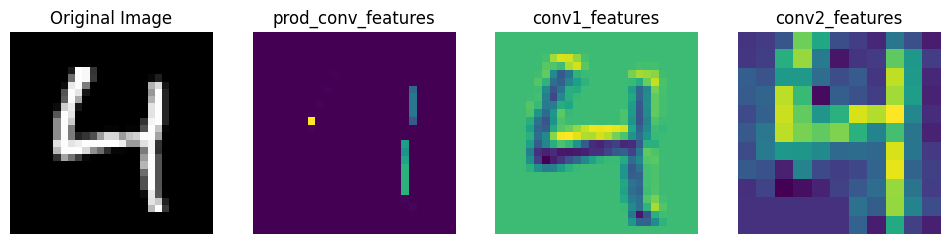

In [6]:

model = ConcatConv2d() #initialize model
model.eval() #set to evaluation mode

# Get the first image from the dataset
data_iter = iter(train_loader)
image, label = next(data_iter)

# Get feature maps
output, prod_conv_features, conv1_features, conv2_features = model(image, return_feature_maps=True)

# Visualize the original image
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(image[0][0], cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Visualize prod_conv_features (show first channel as example)
plt.subplot(1, 4, 2)
plt.imshow(prod_conv_features[0][0].detach().numpy(), cmap='viridis')
plt.title("prod_conv_features")
plt.axis('off')

# Visualize conv1_features (show first channel as example)
plt.subplot(1, 4, 3)
plt.imshow(conv1_features[0][0].detach().numpy(), cmap='viridis')
plt.title("conv1_features")
plt.axis('off')

# Visualize conv2_features (show first channel as example)
plt.subplot(1, 4, 4)
plt.imshow(conv2_features[0][0].detach().numpy(), cmap='viridis')
plt.title("conv2_features")
plt.axis('off')

plt.show()

performing cross validation

In [ ]:

# Define K-Fold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Training loop
num_epochs = 10
learning_rate = 0.001

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data)): # Corrected line: train_dataset
    print(f'FOLD {fold+1}')

    train_subset = Subset(train_data, train_ids)
    val_subset = Subset(test_data, val_ids)

    # train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    # val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

    model = ConcatConv2d(in_channels=1, num_classes=10)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}')

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Epoch {epoch+1}, Val Loss: {val_loss/len(test_loader)}, Val Accuracy: {100 * correct / total}%')

print("Cross-validation complete.")

FOLD 1
Epoch 1, Train Loss: 0.1698486950652053
Epoch 1, Val Loss: 0.03958149503916502, Val Accuracy: 98.72%
Epoch 2, Train Loss: 0.06425821545068175
Epoch 2, Val Loss: 0.03074328281916678, Val Accuracy: 98.98%
Epoch 3, Train Loss: 0.05090065556578338
Epoch 3, Val Loss: 0.02632099011039827, Val Accuracy: 99.16%
Epoch 4, Train Loss: 0.04078197610797361
Epoch 4, Val Loss: 0.024005706772441043, Val Accuracy: 99.24%
Epoch 5, Train Loss: 0.0347144286307351
Epoch 5, Val Loss: 0.021919117605430073, Val Accuracy: 99.21%
Epoch 6, Train Loss: 0.029114462150998104
Epoch 6, Val Loss: 0.021753487620444503, Val Accuracy: 99.3%
Epoch 7, Train Loss: 0.027772285957083417
Epoch 7, Val Loss: 0.02227082177734701, Val Accuracy: 99.18%
Epoch 8, Train Loss: 0.0232894474506611
Epoch 8, Val Loss: 0.020306451663491317, Val Accuracy: 99.37%
Epoch 9, Train Loss: 0.021992304952970394
Epoch 9, Val Loss: 0.020695939564320726, Val Accuracy: 99.32%
Epoch 10, Train Loss: 0.018257489610744717
Epoch 10, Val Loss: 0.019835

--- Epoch 1 ---
	Train loss: 0.1490, acc: 0.9647%
	Val loss: 0.0353, acc: 0.9897%
--- Epoch 2 ---
	Train loss: 0.0616, acc: 0.9820%
	Val loss: 0.0302, acc: 0.9903%
--- Epoch 3 ---
	Train loss: 0.0470, acc: 0.9861%
	Val loss: 0.0233, acc: 0.9917%
--- Epoch 4 ---
	Train loss: 0.0409, acc: 0.9875%
	Val loss: 0.0271, acc: 0.9915%
--- Epoch 5 ---
	Train loss: 0.0331, acc: 0.9899%
	Val loss: 0.0226, acc: 0.9930%
--- Epoch 6 ---
	Train loss: 0.0304, acc: 0.9905%
	Val loss: 0.0214, acc: 0.9935%
--- Epoch 7 ---
	Train loss: 0.0264, acc: 0.9919%
	Val loss: 0.0220, acc: 0.9934%
--- Epoch 8 ---
	Train loss: 0.0250, acc: 0.9920%
	Val loss: 0.0191, acc: 0.9937%
--- Epoch 9 ---
	Train loss: 0.0203, acc: 0.9937%
	Val loss: 0.0201, acc: 0.9935%
--- Epoch 10 ---
	Train loss: 0.0186, acc: 0.9940%
	Val loss: 0.0206, acc: 0.9941%


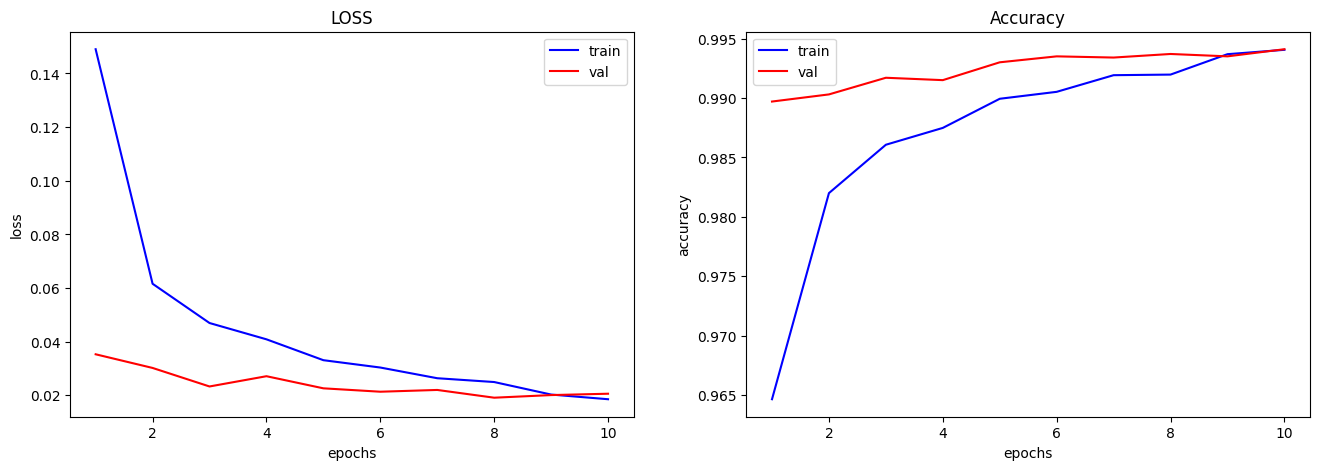

In [7]:
model = ConcatConv2d()

# loss function
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

####TRAIN
def train(epoch):

    # Setting model in training mode.
    model.train()

    train_loss = 0
    train_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        #clear gradient
        optimizer.zero_grad()

        #FP (make a prediction)
        output = model(data.float())

        # calculating the loss
        loss = loss_func(output, target)

        #BP, Computing the gradient of the loss w.r.t the parameters of the model
        loss.backward()

        # a single step of optimization, update parameters
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #clamping
        optimizer.step()

        train_loss += loss.item()

        _, pred = output.max(1)
        train_acc += target.eq(pred).sum().item()

    train_acc /= len(train_loader.dataset)
    train_loss /= (batch_idx + 1) # Average per batch

    return train_loss, train_acc
###TEST

def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(test_loader.dataset)
    return val_loss, val_acc

###PLOT
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

epochs = 10
for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()